In [1]:
import pandas as pd
from pathlib import Path
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, TextBox, Button
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [2]:
from py_banshee.rankcorr import bn_rankcorr
from py_banshee.sample_bn import generate_samples
from py_banshee.bn_plot import bn_visualize
from py_banshee.prediction import inference

In [3]:
data_path = Path(Path().resolve()).parent.parent.parent / 'data' / 'market data'
scenario_path = Path(Path().resolve()).parent.parent.parent / 'data' / 'forecast data' / 'Scenarios'

In [4]:
idm = pd.read_pickle(data_path / 'NL_ID.pickle')

In [5]:
dam = pd.read_pickle(data_path / 'DAM_prices.pkl').loc[:, ['NL']].dropna()
dam.index = dam.index.tz_convert('Europe/Amsterdam')
dam.columns = ['DAM']

In [6]:
n_scenarios = 10
method = 'energy'
name = f'DAM_{method}_{n_scenarios}'
dam_scenarios = pd.read_pickle(scenario_path / f'{name}.pkl')

In [7]:
dam_scenarios

DAM NL +1  DAM NL +2  DAM NL +3  \
date                      scenario                                    
2018-12-30 23:00:00+00:00 0             50.85      52.85      47.55   
                          1             33.50      31.88      31.97   
                          2             36.25      33.40      39.02   
                          3             37.67      37.11      40.06   
                          4             47.94      45.25      44.29   
...                                       ...        ...        ...   
2022-11-27 23:00:00+00:00 5            469.48     461.33     492.88   
                          6            453.60     396.42     450.54   
                          7            491.72     498.79     496.35   
                          8            535.04     519.78     537.93   
                          9            545.42     534.76     523.52   

                                    DAM NL +4  DAM NL +5  DAM NL +6  \
date                      scenario                                    
2018-12-30 23:00:00+00:00 0             42.39      44.20      48.89   
                          1             27.60      22.01      29.80   
                          2             37.51      36.61      44.18   
                          3             36.65      38.40      36.33   
                          4             43.12      41.42      49.24   
...                                       ...        ...        ...   
2022-11-27 23:00:00+00:00 5            489.28     491.70     497.23   
                          6            267.44     399.54     386.38   
                          7            491.49     499.37     522.44   
                          8            535.35     526.65     535.93   
                          9            523.14     518.33     530.37   

                                    DAM NL +7  DAM NL +8  DAM NL +9  \
date                      scenario                                    
2018-12-30 23:00:00+00:00 0             50.52      57.15      68.00   
                          1             38.67      45.69      42.12   
                          2             49.13      57.70      65.07   
                          3             45.59      54.50      56.38   
                          4             50.33      62.76      64.03   
...                                       ...        ...        ...   
2022-11-27 23:00:00+00:00 5            530.52     544.81     549.64   
                          6            503.64     522.71     521.99   
                          7            536.98     549.61     543.75   
                          8            542.24     548.39     541.53   
                          9            540.94     548.49     547.29   

                                    DAM NL +10  ...  DAM NL +40  DAM NL +41  \
date                      scenario              ...                           
2018-12-30 23:00:00+00:00 0              62.38  ...       64.14       66.39   
                          1              43.64  ...       51.03       53.83   
                          2              59.32  ...       68.48       72.07   
                          3              54.58  ...       57.95       65.02   
                          4              60.78  ...       70.72       73.85   
...                                        ...  ...         ...         ...   
2022-11-27 23:00:00+00:00 5             531.12  ...      481.83      506.20   
                          6             466.70  ...      191.68      351.33   
                          7             537.02  ...      364.80      428.26   
                          8             522.99  ...      411.65      465.22   
                          9             525.01  ...      497.00      526.48   

                                    DAM NL +42  DAM NL +43  DAM NL +44  \
date                      scenario                                       
2018-12-30 23:00:00+00:00 0              76.44       78.86       77.27   
              

In [8]:
idm

,ID3,IDx,Volume,Volume3
2015-01-01 00:00:00+01:00,26.3,26.3,99.8,99.8
2015-01-01 01:00:00+01:00,22.88,22.88,138.8,138.8
2015-01-01 02:00:00+01:00,25.0,25.0,12.0,12.0
2015-01-01 03:00:00+01:00,30.0,26.82,11.0,6.0
2015-01-01 04:00:00+01:00,26.68,26.68,19.0,19.0
...,...,...,...,...
2023-01-05 19:00:00+01:00,133.94,146.58,898.8,484.6
2023-01-05 20:00:00+01:00,136.31,135.89,793.8,427.2
2023-01-05 21:00:00+01:00,133.47,130.4,758.8,433.9
2023-01-05 22:00:00+01:00,121.63,123.9,709.9,456.4


In [9]:
n_dam_prices = 24 + 1
n_intraday_prices = 24 + 1

# Initiate the structure
# 48h forecast + current observation
# [current DAM] + [48 DAM forecasts] + [current ID] + [24 ID forecasts]
bn_structure = [[] for _ in range(n_dam_prices)] + [[] for _ in range(n_intraday_prices)]

# No need to connect the DAM prices since these come from data
# Connect intraday prices to 3 surrounding dam prices
for i in range(n_intraday_prices):
    id_node = n_dam_prices + i
    
    # Get the DAM nodes
    dam_nodes = [i - 1, i, i + 1]

    # Delete the nodes that do not exist
    dam_nodes = [node for node in dam_nodes if node >= 0 and node < n_dam_prices]

    # Now connect the ID prices to the previous ID node
    id_nodes = [id_node - 1]

    # Delete the nodes that do not exist
    id_nodes = [node for node in id_nodes if node >= n_dam_prices and node < n_dam_prices + n_intraday_prices]

    # Add the nodes to the structure
    bn_structure[id_node] = dam_nodes + id_nodes

In [10]:
dam.shift(-1)

,DAM
2018-01-01 00:00:00+01:00,27.30
2018-01-01 01:00:00+01:00,30.10
2018-01-01 02:00:00+01:00,20.87
2018-01-01 03:00:00+01:00,25.56
2018-01-01 04:00:00+01:00,25.58
...,...
2023-01-01 19:00:00+01:00,62.00
2023-01-01 20:00:00+01:00,52.93
2023-01-01 21:00:00+01:00,45.96
2023-01-01 22:00:00+01:00,35.00


# BN of P(IDM|DAM)

In [11]:
dam_grouped = pd.DataFrame(index=dam.loc[dam.index.hour==0].index, columns=[f'DAM{i}' for i in range(1, n_dam_prices)])
idm_grouped = pd.DataFrame(index=idm.loc[idm.index.hour==0].index, columns=[f'IDM{i}' for i in range(1, n_intraday_prices)])

for i in range(1, n_dam_prices):
    dam_grouped[f'DAM{i}'] = dam.shift(-i).loc[dam.index.hour==0, 'DAM']
    if i < n_intraday_prices:
        idm_grouped[f'IDM{i}'] = idm.shift(-i).loc[idm.index.hour==0, 'ID3']

dam_grouped = dam_grouped.dropna()
idm_grouped = idm_grouped.dropna()

year = 2018
maxdate = dam_grouped.loc[dam_grouped.index.year==year].index.max() + pd.Timedelta(days=1)
dam_grouped = dam_grouped.loc[dam_grouped.index <= maxdate]
idm_grouped = idm_grouped.loc[idm_grouped.index <= maxdate]

bn_data = pd.DataFrame(index=dam_grouped.index, columns=[['DAM0'] + [f'DAM{i}' for i in range(1, n_dam_prices)] + ['IDM0'] + [f'IDM{i}' for i in range(1, n_intraday_prices)]])
bn_data['DAM0'] = dam_grouped['DAM24'].shift(-1)
bn_data['IDM0'] = idm_grouped['IDM24'].shift(-1)
bn_data[[f'DAM{i}' for i in range(1, n_dam_prices)]] = dam_grouped[[f'DAM{i}' for i in range(1, n_dam_prices)]]
bn_data[[f'IDM{i}' for i in range(1, n_intraday_prices)]] = idm_grouped[[f'IDM{i}' for i in range(1, n_intraday_prices)]]

bn_data = bn_data.dropna()


In [12]:
idm_grouped

,IDM1,IDM2,IDM3,IDM4,IDM5,IDM6,IDM7,IDM8,IDM9,IDM10,...,IDM15,IDM16,IDM17,IDM18,IDM19,IDM20,IDM21,IDM22,IDM23,IDM24
2015-01-06 00:00:00+01:00,35.56,34.33,32.58,34.0,36.36,40.0,43.0,44.0,48.32,49.53,...,45.07,47.82,44.18,43.09,46.67,33.84,33.57,30.85,31.86,30.13
2015-02-22 00:00:00+01:00,39.78,39.41,37.0,41.47,50.0,41.11,43.0,43.0,60.0,50.0,...,47.14,46.58,45.91,30.0,25.0,57.04,43.39,35.5,55.0,26.0
2015-03-08 00:00:00+01:00,31.0,34.25,32.74,33.1,26.72,28.0,38.0,38.0,20.0,24.0,...,13.47,11.67,20.9,21.15,33.2,25.0,38.0,39.0,38.0,40.0
2015-03-31 00:00:00+02:00,22.41,25.06,30.0,27.03,30.75,36.0,36.96,68.27,65.0,60.0,...,63.34,61.13,56.71,55.91,52.17,56.36,49.7,41.2,48.0,40.67
2015-04-24 00:00:00+02:00,33.75,30.0,33.05,38.29,30.0,30.0,47.45,53.82,55.16,51.57,...,38.67,36.25,47.99,43.56,44.28,37.08,20.0,42.32,36.0,28.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26 00:00:00+01:00,27.97,35.29,33.95,42.83,45.39,38.31,52.98,62.43,79.42,83.22,...,76.46,86.04,109.96,90.14,83.49,71.61,57.49,60.3,55.85,51.18
2018-12-27 00:00:00+01:00,57.06,53.4,51.31,54.26,54.72,51.41,72.36,70.74,86.01,75.1,...,67.54,68.72,70.11,70.44,68.67,68.94,64.35,67.6,58.18,51.49
2018-12-28 00:00:00+01:00,48.37,51.42,50.87,52.26,52.24,53.5,56.1,59.9,63.81,60.94,...,61.11,65.54,71.78,65.15,61.68,60.66,53.98,53.37,54.7,50.8
2018-12-31 00:00:00+01:00,52.04,50.98,49.73,50.64,52.22,54.61,62.0,66.35,64.21,65.73,...,61.16,61.15,64.92,74.54,82.88,53.75,50.59,52.47,44.69,85.51


In [13]:
R = bn_rankcorr(parent_cell=bn_structure, data=bn_data, var_names=bn_data.columns, is_data=True)
scaled=False

# BN of P(IDM/DAM | DAM)

In [14]:
bn_data_scaled_norm = bn_data.copy()

for h in range(25):
    bn_data_scaled_norm[f'IDM{h}'] = bn_data_scaled_norm[f'IDM{h}'].values.flatten() / bn_data_scaled_norm[f'DAM{h}'].values.flatten()

In [15]:
R = bn_rankcorr(parent_cell=bn_structure, data=bn_data_scaled_norm, var_names=bn_data.columns, is_data=True)
scaled=True

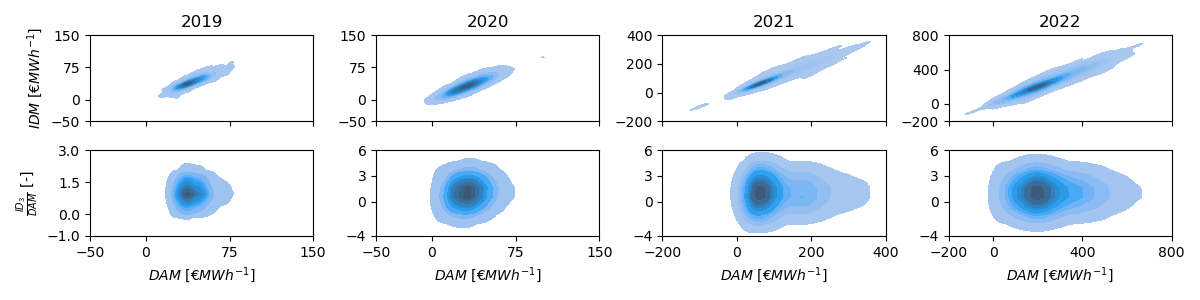

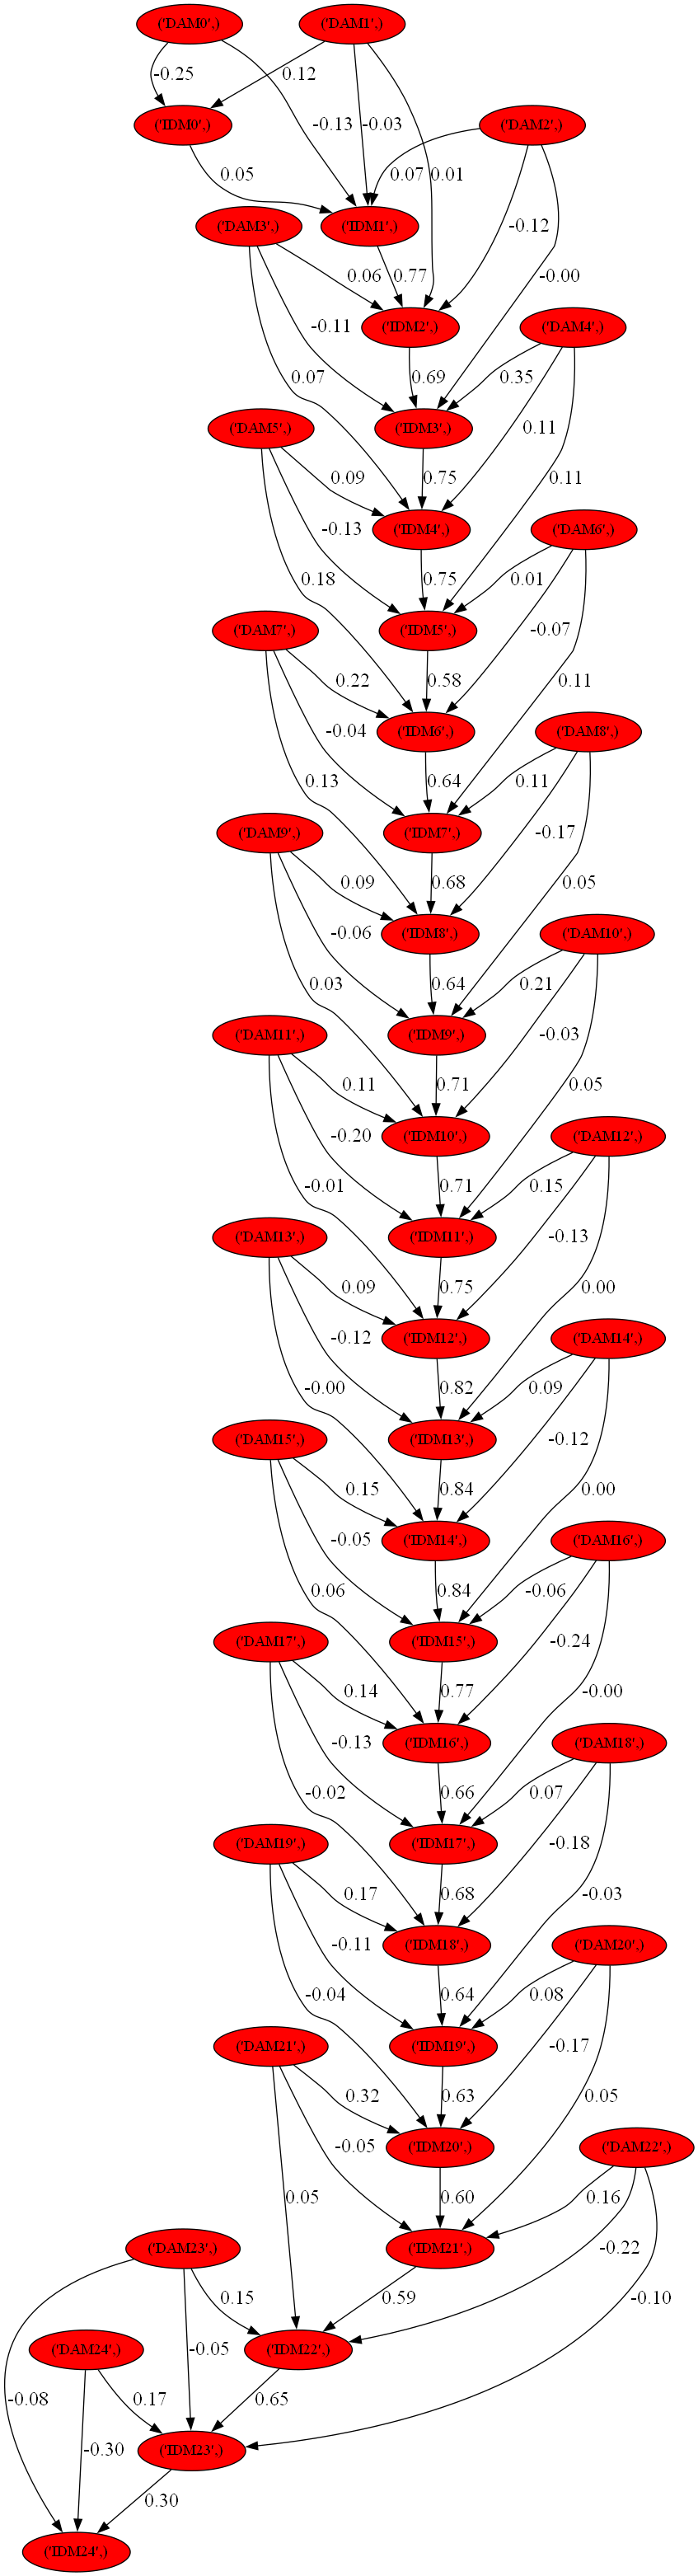

In [41]:
bn_visualize(R=R, names=bn_data.columns, parent_cell=bn_structure)#, title='Rank correlation', figsize=(10, 10), cmap='RdBu_r', vmin=-1, vmax=1, show=False)


In [17]:
# class IDM_BN():
#     """
#     Class for the IDM BN. Conditionalizes IDM prices on DAM prices.
#     """
#     def __init__(self, bn_data, bn_structure=None, normalize_idm=True, pred_hor=24, R=None, mask=True, mask_method='std', mask_factor=3, mask_by_hour=False):
#         self.bn_data = bn_data.copy()
#         self.bn_structure = bn_structure
#         self.normalize = normalize_idm
#         self.pred_hor = pred_hor

#         # Normalize the data
#         if self.normalize:
#             self.normalize_data()
        
#         # Include the current stap to the amount of prices
#         self.n_dam_prices = pred_hor+1
#         self.n_intraday_prices = pred_hor+1

#         # Initiate the structure
#         if self.bn_structure is None:
#             self.make_structure()

#         self.R = R
#         # Initiate the BN
#         if self.R is None:
#             self.R = bn_rankcorr(parent_cell=self.bn_structure, data=self.bn_data, var_names=self.bn_data.columns, is_data=True)

#         self.make_mask(mask, mask_factor, mask_method, mask_by_hour)
    
#     def make_mask(self, mask, factor=4, how='std', mask_by_hour=False):
#         # Masks the output of the ID price of the BN to 'factor' times the standard deviation of the DAM price
#         if mask and not mask_by_hour:
#             if how == 'std':
#                 mask_std = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].values.flatten().std()
#                 mask_mean = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].values.flatten().mean()

#                 self.mask = (mask_mean - factor*mask_std, mask_mean + factor*mask_std)
#             elif how == 'minmax':
#                 mask_min = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].values.flatten().min()
#                 mask_max = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].values.flatten().max()

#                 mask_min = min(mask_min*factor, mask_min/factor)
#                 mask_max = max(mask_max*factor, mask_max/factor)
#                 self.mask = (mask_min, mask_max)
#             else:
#                 raise ValueError(f'Unknown how: {how}')
#         elif mask and mask_by_hour:
#             if how == 'std':
#                 mask_stds = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].std().values
#                 mask_means = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].mean().values
#                 self.mask = (mask_means - factor*mask_stds, mask_means + factor*mask_stds)
#             elif how == 'minmax':
#                 mask_mins = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].min().values
#                 mask_maxs = self.bn_data.loc[:, [f'IDM{h}' for h in range(self.pred_hor+1)]].max().values

#                 mask_mins = np.minimum(mask_mins*factor, mask_mins/factor)
#                 mask_maxs = np.maximum(mask_maxs*factor, mask_maxs/factor)
#                 self.mask = (mask_mins, mask_maxs)

#             print(self.mask)
#         else:
#             self.mask = None

#     def apply_mask(self, data):
#         if self.mask is None:
#             return data
        
#         if self.mask[0].shape[0] == 1:
#             data[data<self.mask[0]] = self.mask[0]
#             data[data>self.mask[1]] = self.mask[1]
#         else:
#             h0 = self.n_intraday_prices - data.shape[1]
#             for i in range(data.shape[1]):
#                 # Loop through all the hours
#                 min_mask = self.mask[0][i+h0]
#                 max_mask = self.mask[1][i+h0]

#                 data[:, i][data[:, i]<min_mask] = min_mask
#                 data[:, i][data[:, i]>max_mask] = max_mask
                
#         return data
    
#     def make_structure(self):
#         # Initiate the structure
#         # N h forecast + current observation
#         # [current DAM] + [N DAM forecasts] + [current ID] + [N ID forecasts]
#         self.bn_structure = [[] for _ in range(self.n_dam_prices)] + [[] for _ in range(self.n_intraday_prices)]

#         # No need to connect the DAM prices since these come from data / forecasts
#         # Connect intraday prices to 3 surrounding dam prices
#         for i in range(self.n_intraday_prices):
#             id_node = self.n_dam_prices + i
            
#             # Get the DAM nodes
#             dam_nodes = [i - 1, i, i + 1]

#             # Delete the nodes that do not exist
#             dam_nodes = [node for node in dam_nodes if node >= 0 and node < self.n_dam_prices]

#             # Now connect the ID prices to the previous ID node
#             id_nodes = [id_node - 1]

#             # Delete the nodes that do not exist
#             id_nodes = [node for node in id_nodes if node >= self.n_dam_prices and node < self.n_dam_prices + self.n_intraday_prices]

#             # Add the nodes to the structure
#             self.bn_structure[id_node] = dam_nodes + id_nodes

#     def normalize_data(self):
#         """
#         Normalize the data by dividing the IDM prices by the DAM prices
#         """
#         if self.normalize:
#             for h in range(self.pred_hor+1):
#                 self.bn_data[f'IDM{h}'] = self.bn_data[f'IDM{h}'].values.flatten() / self.bn_data[f'DAM{h}'].values.flatten()

#     def normalize_input(self, idm_observations, dam_prices):
#         """
#         Normalize the data by dividing the IDM prices by the DAM prices
#         """
#         if self.normalize:
#             # Only select the first DAM prices to cover the IDM observations
#             dam_prices = dam_prices[:len(idm_observations)].values.flatten()
#             idm_observations = idm_observations / dam_prices
#         return idm_observations
    
#     def denormalize_samples(self, samples, dam_prices):
#         """
#         Denormalize the samples to get the IDM prices
#         """
#         if self.normalize:
#             # Only select the last DAM prices to cover the IDM samples
#             # dam_prices = dam_prices[-len(samples):].values.flatten()
#             samples = samples * dam_prices.reshape(1, -1)
#         return samples
    
#     def infer_idm(self, dam_scenario, idm_observations, n_samples=1000, is_normalized=False):
#         """
#         Infer the IDM prices given the DAM prices.

#         Parameters
#         ----------
#         dam_scenario : np.array
#             Array of DAM prices to condition the IDM on.
#             Should be of length pred_hor + 1 (to properly condition the first IDM price).
#         idm_observations : np.array
#             Array of IDM prices to condition the IDM on.
#             Minimum length is 1 (the IDM price of d-1), untill 1 + pred_hor
#         """
#         h = len(idm_observations) - 1
#         # Define condition nodes
#         condition_nodes = [i for i in range(self.n_dam_prices + 1 + h)] # DAM prices + IDM price of d-1 + IDM prices untill h
        
#         if not is_normalized and self.normalize:
#             # Normalize the input
#             idm_observations = self.normalize_input(idm_observations, dam_scenario)
        
#         condition_values = list(np.concatenate([dam_scenario, idm_observations]))

#         # Infer IDM prices given the DAM prices and the observed IDM prices
#         samples = inference(
#             R=self.R,
#             Nodes=condition_nodes,
#             Values=condition_values,
#             DATA=self.bn_data,
#             SampleSize=n_samples
#         )

#         samples=samples[0].T # shape [n_samples, n_idm_prices]
#         samples = self.apply_mask(samples)
#         if self.normalize:
#             # Denormalize the samples
#             samples = self.denormalize_samples(samples, dam_scenario[h+1:])

#         return samples
    
#     def __call__(self, i, h, n_samples=100):
#         """
#         Get the conditional nodes for the IDM price at bn_data index i and hour h

#         Parameters
#         ----------
#         i : int
#             Index of the bn_data to get the conditional nodes for.
#         h : int
#             Hour to get the conditional nodes for. Minimum value is 1 (the IDM price of d-1), untill 1 + pred_hor
#         """
#         if h > self.pred_hor:
#             raise ValueError(f'Hour h should be smaller than the prediction horizon {self.pred_hor}')
#         elif h < 1:
#             raise ValueError(f'Hour h should be larger than 0')
#         elif i < 0 or i >= len(self.bn_data):
#             raise ValueError(f'Index i should be between 0 and {len(self.bn_data)}')
        
#         # Get the dam prices
#         dam_prices = self.bn_data.iloc[i, :self.n_dam_prices].to_numpy()
#         idm_observations = self.bn_data.iloc[i, self.n_dam_prices:self.n_dam_prices+h].to_numpy()

#         # Infer the IDM prices
#         return self.infer_idm(dam_prices, idm_observations, n_samples=n_samples, is_normalized=True)

In [18]:
from utils.scenario_gen import IDM_BN

In [19]:
bn = IDM_BN(bn_data=bn_data, bn_structure=None, normalize_idm=True, bn_data_is_normalized=False, pred_hor=24, mask_factor=4, mask_method='std', mask_by_hour=True)

0

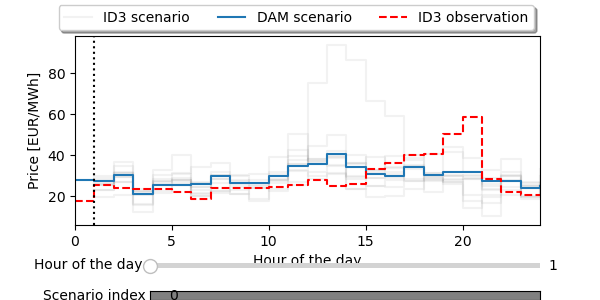

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.subplots_adjust(bottom=0.25)

# Now make a plot with sliders to control the amount of observed hour of the day and index of the original scenario set
where='post'
# index_slider = Slider(ax=plt.axes([0.25, 0.1, 0.65, 0.03]), label='Scenario index', valmin=0, valmax=bn_data.shape[0] - 1, valinit=0, valstep=1)

i0=0
h0=1
n_samples=10

hour_slider = Slider(ax=plt.axes([0.25, 0.1, 0.65, 0.03]), label='Hour of the day', valmin=1, valmax=24, valinit=h0, valstep=1)
index_textbox = TextBox(ax=plt.axes([0.25, 0, 0.65, 0.03]), label='Scenario index', initial=str(i0), color='grey', hovercolor='white')


# Initiate the plot
samples = bn(i0, h0, n_samples=n_samples)

for i in range(n_samples):
    if i == 0:
        ax.step(range(h0, 25), samples[i, :], label='ID3 scenario', where=where, color='grey', alpha=0.1)
    else:
        ax.step(range(h0, 25), samples[i, :], where=where, color='grey', alpha=0.1)

ax.step(range(25), bn_data.iloc[i0, :25], label='DAM scenario', where=where)
ax.step(range(25), bn_data.iloc[i0, 25:], label='ID3 observation', color='red', linestyle='--', where=where)
ax.axvline(x=h0, color='black', linestyle=':')

ax.set_xlabel('Hour of the day')
ax.set_ylabel('Price [EUR/MWh]')
ax.set_title('Scenario generation')
ax.legend(loc='upper left', bbox_to_anchor=(-0.05, 1.2), ncol=3, fancybox=True, shadow=True)
ax.set_xlim([0, 24])



# Update the plot
def update(val):
    # Update the scenario based on hour value and the index in the textbox
    i0 = int(index_textbox.text)
    h0 = int(hour_slider.val)

    ax.clear()
    # Initiate the plot
    samples = bn(i0, h0, n_samples=n_samples)

    for i in range(n_samples):
        if i == 0:
            ax.step(range(h0, 25), samples[i, :], label='ID3 scenario', where=where, color='grey', alpha=0.1)
        else:
            ax.step(range(h0, 25), samples[i, :], where=where, color='grey', alpha=0.1)

    ax.step(range(25), bn_data.iloc[i0, :25], label='DAM scenario', where=where)
    ax.step(range(25), bn_data.iloc[i0, 25:], label='ID3 observation', color='red', linestyle='--', where=where)
    ax.axvline(x=h0, color='black', linestyle=':')

    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Price [EUR/MWh]')
    ax.set_title('Scenario generation')
    ax.legend(loc='upper left', bbox_to_anchor=(-0.05, 1.2), ncol=3, fancybox=True, shadow=True)
    ax.set_xlim([0, 24])
    fig.canvas.draw_idle()
    # plt.show()

# index_slider.on_changed(update)
hour_slider.on_changed(update)
index_textbox.on_submit(update)
# plt.show()


In [21]:
sns.heatmap(samples.corr())


AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [ ]:
samples.shape

(25, 24)

<Axes: >

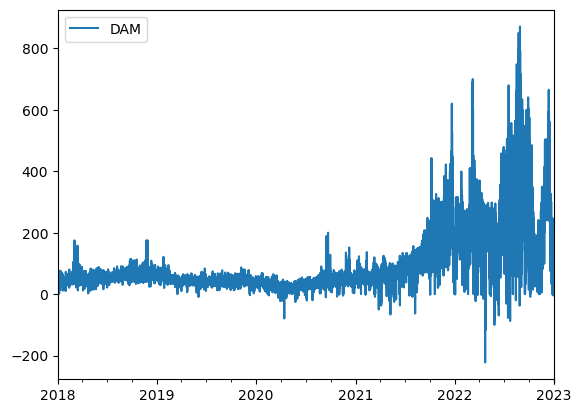

In [ ]:
dam.plot()

In [38]:
def lims(year, title):
    if title=='idm':
        if year==2019:
            return [-50, 150]
        elif year == 2020:
            return [-50, 150]
        elif year == 2021:
            return [-100, 400]
        elif year==2022:
            return [-100, 800]

    elif title=='diff':
        if year==2019:
            return [-50, 50]
        elif year == 2020:
            return [-50, 50]
        elif year == 2021:
            return [-100, 100]
        elif year == 2022:
            return [-200, 200]
    
    elif title=='rel_diff':
        if year == 2019:
            return [-5, 5]
        elif year==2020:
            return [-5, 5]
        elif year==2021:
            return [-5, 5]
        elif year==2022:
            return [-5, 5]

    elif title=='rel':
        if year==2019:
            return [-1, 3]
        elif year == 2020:
            return [-4, 6]
        elif year == 2021:
            return [-4, 6]
        elif year == 2022:
            return [-4, 6]

    elif title=='dam':
        if year==2019:
            return [-50, 150]
        if year == 2020:
            return [-50, 150]
        if year == 2021:
            return [-200, 400]
        if year == 2022:
            return [-200, 800]


In [ ]:
year = 2022

def plot_year(year, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    plot_df = idm.loc[:, ['ID3']].dropna().copy()
    plot_df['DAM'] = dam['DAM']
    plot_df = plot_df.loc[plot_df.index.year == year, :]

    i = 0
    # Prices over DAM
    sns.kdeplot(x=plot_df['DAM'], y=plot_df['ID3'], ax=ax[i], fill=True)#, thresh=0.05)
    # ax[i].set_xlim(lims(year, 'dam'))
    # ax[i].set_ylim(lims(year, 'idm'))
    ax[i].set_xlim(-100, 700)
    ax[i].set_ylim(-100, 700)
    ax[i].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    ax[i].set_ylabel(f'{year} \n' + r'$ID_3$ [$€ MWh^{-1}$]')
    i += 1

    # # Absolute difference over DAM price
    # plot_df['DAM_diff'] = plot_df['DAM'] - plot_df['ID3']
    # sns.kdeplot(x=plot_df['DAM'], y=plot_df['DAM_diff'], ax=ax[i], fill=True)#, shade_lowest=False)
    # ax[i].set_xlim(lims(year, 'dam'))
    # ax[i].set_ylim(lims(year, 'diff'))
    # ax[i].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    # ax[i].set_ylabel(r'$DAM - ID_3$ [$€ MWh^{-1}$]')
    # i += 1

    # # Relative difference over DAM price
    # plot_df['DAM_rel_diff'] = plot_df['DAM_diff'] / plot_df['DAM']
    # plot_df.loc[plot_df['DAM_rel_diff'] < -100] = -100
    # plot_df.loc[plot_df['DAM_rel_diff'] > 100] = 100
    # sns.kdeplot(x=plot_df['DAM'], y=plot_df['DAM_rel_diff'], ax=ax[i], fill=True)#, shade_lowest=False)
    # ax[i].set_xlim(lims(year, 'dam'))
    # ax[i].set_ylim(lims(year, 'rel_diff'))
    # ax[i].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    # ax[i].set_ylabel(r'$\frac{DAM - ID_3}{DAM}$ [-]')
    # i += 1

    # Relative prices over DAM price
    plot_df['DAM_rel'] = plot_df['ID3'] / plot_df['DAM']
    plot_df.loc[plot_df['DAM_rel'] < -100] = -100
    plot_df.loc[plot_df['DAM_rel'] > 100] = 100
    sns.kdeplot(x=plot_df['DAM'], y=plot_df['DAM_rel'], ax=ax[i], fill=True)#, shade_lowest=False)
    # ax[i].set_xlim(lims(year, 'dam'))
    # ax[i].set_ylim(lims(year, 'rel'))
    ax[i].set_xlim(-100, 700)
    ax[i].set_ylim(-3, 3)
    ax[i].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    ax[i].set_ylabel(r'$\frac{ID_3}{DAM}$ [-]')
    i += 1

    return ax


In [24]:
xy = {}
for i, year in enumerate(tqdm([2019, 2020, 2021, 2022])):
    plot_df = idm.loc[:, ['ID3']].dropna().copy()
    plot_df['DAM'] = dam['DAM']
    plot_df = plot_df.loc[plot_df.index.year == year, :]
    # Relative prices over DAM price
    plot_df['DAM_rel'] = plot_df['ID3'] / plot_df['DAM']
    plot_df.loc[plot_df['DAM_rel'] < -100] = -100
    plot_df.loc[plot_df['DAM_rel'] > 100] = 100

    xy [year] = plot_df.copy()

100%|██████████| 4/4 [00:00<00:00, 55.41it/s]


In [39]:
def ticks(year, title):
    if title == 'dam':
        if year == 2019:
            ticks = [-50, 0, 75, 150]
        elif year == 2020:
            ticks = [-50, 0, 75, 150]
        elif year == 2021:
            ticks = [-200, 0, 200, 400]
        elif year == 2022:
            ticks = [-200, 0, 400, 800]
    elif title == 'idm':
        if year == 2019:
            ticks = [-50, 0, 75, 150]
        elif year == 2020:
            ticks = [-50, 0, 75, 150]
        elif year == 2021:
            ticks = [-200, 0, 200, 400]
        elif year == 2022:
            ticks = [-200, 0, 400, 800]
    elif title == 'rel':
        if year == 2019:
            ticks = [-1, 0, 1.5, 3]
        else:
            ticks = [-4, 0, 3, 6]
    return ticks

100%|██████████| 4/4 [01:01<00:00, 15.32s/it]


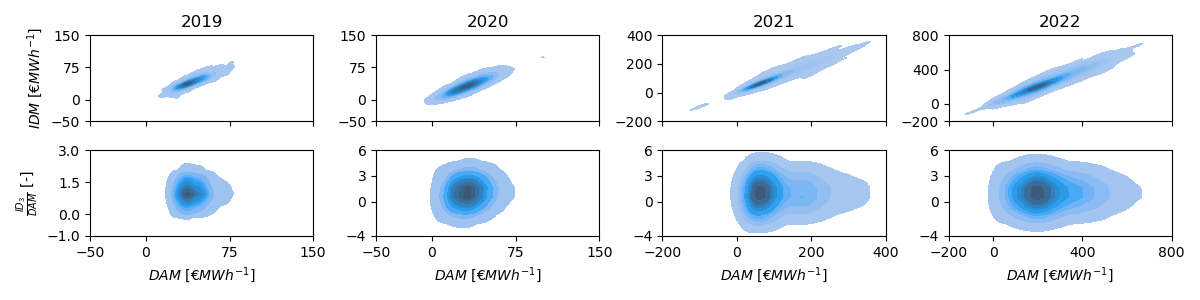

In [40]:
fig, ax = plt.subplots(2, 4, figsize=(12,3), sharex='col')
for i, year in enumerate(tqdm([2019,2020,2021,2022])):
    sns.kdeplot(x=xy[year]['DAM'], y=xy[year]['ID3'], ax=ax[0,i], fill=True)
    sns.kdeplot(x=xy[year]['DAM'], y=xy[year]['DAM_rel'], ax=ax[1,i], fill=True)
    ax[0,i].set_title(year)

    damlims = lims(year, 'dam')
    idmlims = lims(year, 'idm')
    rellimes = lims(year, 'rel')

    ax[0,i].set_xlim(damlims)
    ax[0,i].set_ylim(idmlims)
    ax[1,i].set_xlim(damlims)
    ax[1,i].set_ylim(rellimes)
    
    ax[1,i].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    ax[0,i].set_ylabel(None)
    ax[1,i].set_ylabel(None)
    
    ax[0, i].set_xticks(ticks(year, 'dam'))
    ax[0, i].set_yticks(ticks(year, 'idm'))
    ax[1, i].set_xticks(ticks(year, 'dam'))
    ax[1, i].set_yticks(ticks(year, 'rel'))
    
ax[0,0].set_ylabel(r'$IDM$ [$€ MWh^{-1}$]')
ax[1,0].set_ylabel(r'$\frac{ID_3}{DAM}$ [-]')
fig.tight_layout()
fig.savefig('figures/idm_data.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig.savefig('figures/idm_data.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 4/4 [00:57<00:00, 14.37s/it]


PermissionError: [Errno 13] Permission denied: 'figures/idm_data.pdf'

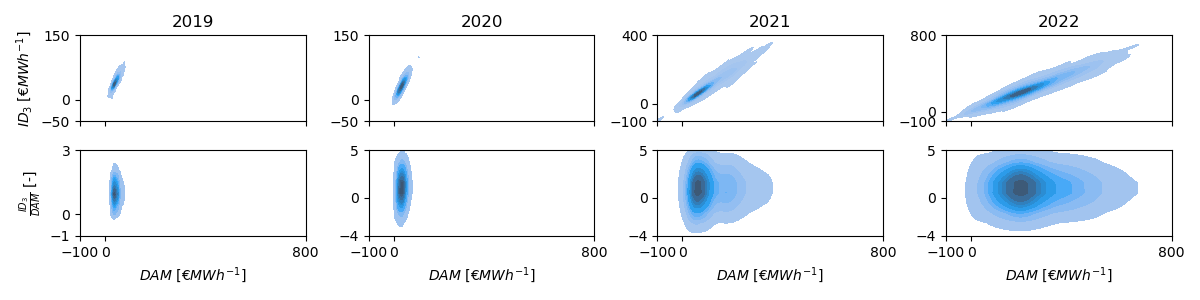

In [59]:
fig, ax = plt.subplots(2, 4, figsize=(12,3), sharex=True)

for i, year in enumerate(tqdm([2019, 2020, 2021, 2022])):
    sns.kdeplot(x=xy[year]['DAM'], y=xy[year]['ID3'], ax=ax[0, i], fill=True)#, thresh=0.05)
    sns.kdeplot(x=xy[year]['DAM'], y=xy[year]['DAM_rel'], ax=ax[1, i], fill=True)#, thresh=0.05)

    damlims = lims(year, 'dam')
    idmlims = lims(year, 'idm')
    rellims = lims(year, 'rel')

    ax[0,i].set_xlim(damlims)
    ax[0,i].set_ylim(idmlims)
    ax[0,i].set_yticks([idmlims[0], 0, idmlims[1]])
    ax[0,i].set_xticks([damlims[0], 0, damlims[1]])

    ax[1,i].set_xlim(damlims)
    ax[1,i].set_ylim(rellims)
    ax[1,i].set_yticks([rellims[0], 0, rellims[1]])
    ax[1,i].set_xticks([damlims[0], 0, damlims[1]])

    ax[0,i].set_title(year)
    ax[1,i].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    ax[0,i].set_ylabel(None)
    ax[1,i].set_ylabel(None)

# ax[0,0].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
ax[0,0].set_ylabel(r'$ID_3$ [$€ MWh^{-1}$]')
ax[1,0].set_ylabel(r'$\frac{ID_3}{DAM}$ [-]')

fig.tight_layout()
fig.savefig('figures/idm_data.pdf', dpi=300, bbox_inches='tight')

In [56]:
fig.savefig('figures/idm_data.pdf', dpi=300, bbox_inches='tight')

In [41]:
# fig, ax = plt.subplots(4, 2, figsize=(6, 6))
# for i, year in enumerate(tqdm([2019, 2020, 2021, 2022])):
#     plot_year(year, ax[i, :])
# fig.tight_layout()



In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(6,6))

In [12]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
vols = [idm.loc[idm.index.year==y, 'Volume'].sum() for y in years]

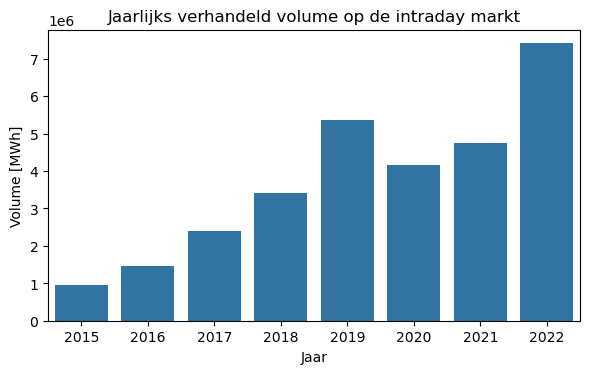

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x=years, y=vols, color='C0')
ax.set_xlabel('Jaar')
ax.set_ylabel('Volume [MWh]')
ax.set_title('Jaarlijks verhandeld volume op de intraday markt')

fig.tight_layout()


In [14]:
dam.values.reshape(-1, 24).shape

(1827, 24)

In [15]:
dam_grouped = pd.DataFrame(index=dam.loc[dam.index.hour==0].index, columns=[c for c in range(24)])
for h in range(24):
    dam_grouped.loc[:, h] = dam.loc[dam.index.hour==h].values

C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\164324094.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dam_grouped.loc[:, h] = dam.loc[dam.index.hour==h].values


In [16]:
id3_grouped = pd.DataFrame(index=idm.loc[idm.index.hour==0].index, columns=[c for c in range(24)])
for h in range(24):
    id3_grouped.loc[:, h] = idm.loc[idm.index.hour==h, 'ID3'].values

# id3_grouped.dropna()

In [18]:
dam_grouped = dam_grouped.loc[dam_grouped.index.isin(id3_grouped.dropna().index), :].dropna()
id3_grouped = id3_grouped.loc[id3_grouped.index.isin(dam_grouped.index), :]

In [55]:
year = 2021
prices = pd.concat([dam_grouped.loc[dam_grouped.index.year==year, :], idm_grouped.loc[idm_grouped.index.year==year, :]], axis=1)
prices.columns = [f'DAM H{i}' for i in range(24)] + [f'IDM H{i}' for i in range(24)]

  0%|          | 0/24 [00:00<?, ?it/s]

3.8108581436077062 -560.0


  8%|▊         | 2/24 [00:00<00:05,  4.36it/s]

26.082089552238806 -3.0999999999999996


C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


18.34831460674157 -690.0


 12%|█▎        | 3/24 [00:00<00:04,  4.26it/s]C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in divide
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
 17%|█▋        | 4/24 [00:00<00:04,  4.41it/s]

nan nan


C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in divide
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
 21%|██        | 5/24 [00:01<00:04,  4.62it/s]

nan nan


C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


68.25 -1626.5


 25%|██▌       | 6/24 [00:01<00:04,  4.47it/s]C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


173.0 -1.5647826086956522


 33%|███▎      | 8/24 [00:01<00:03,  4.53it/s]

302.6666666666667 -131.0


 38%|███▊      | 9/24 [00:01<00:03,  4.79it/s]C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


11.3955223880597 -35.76470588235294
2.7544554455445547 -2.1601830663615558


 42%|████▏     | 10/24 [00:02<00:02,  5.28it/s]

478.0 -7.449579831932773


 50%|█████     | 12/24 [00:02<00:02,  4.80it/s]

315.0 -591.8571428571428


C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
 54%|█████▍    | 13/24 [00:02<00:02,  5.06it/s]C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initia

2.931 0.29175295407479596
10.137373737373737 -261.7


 62%|██████▎   | 15/24 [00:03<00:01,  4.98it/s]

34.528846153846146 -15.25242718446602
3597.9999999999995 -21.71264367816092


 67%|██████▋   | 16/24 [00:03<00:01,  4.68it/s]

23.645161290322577 -2813.0


 71%|███████   | 17/24 [00:03<00:01,  4.52it/s]C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\376317444.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  rel_id3_ = id3s_ / dams_
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
 75%|███████▌  | 18/24 [00:03<00:01,  5.08it/s]

1.888440366972477 0.47767169695103173
1.8780867630700777 0.3645066273932253


 83%|████████▎ | 20/24 [00:04<00:00,  5.95it/s]

2.370782547253136 0.3488205861329521
1.7525446133509583 0.3712086917157085


 92%|█████████▏| 22/24 [00:04<00:00,  6.46it/s]

2.0145045045045045 0.22396221725080787
2.2564761904761905 0.03090676883780332


100%|██████████| 24/24 [00:04<00:00,  5.14it/s]


2.955622009569378 0.11464546056991386


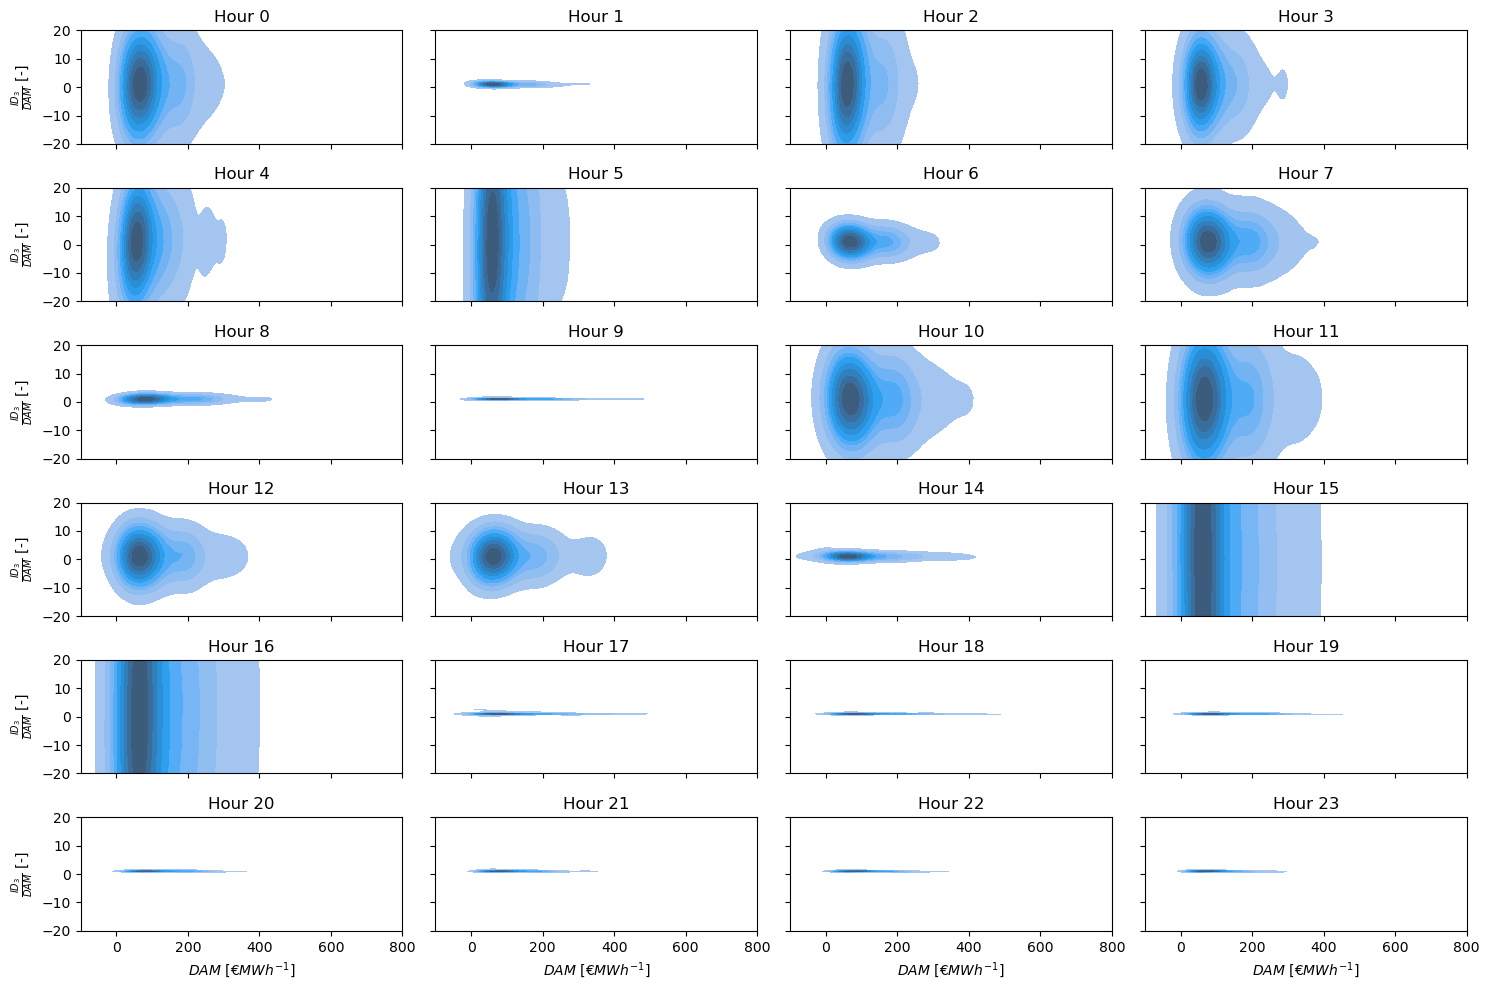

In [26]:
# Plot hourly ID3/DAM KDEs
years=[2021]
fig, ax = plt.subplots(6, 4, figsize=(15, 10), sharex=True, sharey=True)
for hour in tqdm(range(24)):
    dams_ = dam_grouped.loc[dam_grouped.index.year.isin(years), hour].values
    id3s_ = id3_grouped.loc[id3_grouped.index.year.isin(years), hour].values
    rel_id3_ = id3s_ / dams_
    rel_id3_[rel_id3_ == np.inf] = np.nan
    rel_id3_[rel_id3_ == -np.inf] = np.nan
    print(rel_id3_.max(), rel_id3_.min())
    sns.kdeplot(x=dams_, y=rel_id3_, ax=ax[hour//4, hour%4], fill=True)

    damlims = (min(lims(year, 'dam') for year in years), max(lims(year, 'dam') for year in years))
    ax[hour//4, hour%4].set_xlim(lims(year, 'dam'))
    ax[hour//4, hour%4].set_ylim((-20, 20))
    ax[hour//4, hour%4].set_title(f'Hour {hour}')

    if hour//4 == 5:
        ax[hour//4, hour%4].set_xlabel(r'$DAM$ [$€ MWh^{-1}$]')
    if hour%4 == 0:
        ax[hour//4, hour%4].set_ylabel(r'$\frac{ID_3}{DAM}$ [-]')
plt.tight_layout()

C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\3709085067.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rel_idm_bins.loc[:, h] = np.digitize(dam_grouped.loc[dam_grouped.index.year==year, h], bins)
C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\3709085067.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rel_idm_bins.loc[:, h] = np.digitize(dam_grouped.loc[dam_grouped.index.year==year, h], bins)
C:\Users\Heijden\AppData\Local\Temp\ipykernel_51052\3709085067.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = new

Text(0.5, 1.0, 'Relative IDM prices for 2022')

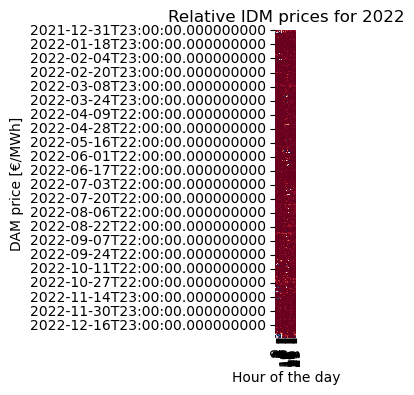

In [25]:
rel_idm = id3_grouped.loc[id3_grouped.index.year==year, :] / dam_grouped.loc[dam_grouped.index.year==year, :]

# bin the relative prices based on the DAM prices
max_dam = dam_grouped.loc[dam_grouped.index.year==year, :].max().max()
min_dam = dam_grouped.loc[dam_grouped.index.year==year, :].min().min()
bins = np.linspace(min_dam, max_dam, 100)
rel_idm_bins = pd.DataFrame(index=rel_idm.index, columns=rel_idm.columns)
for h in range(24):
    rel_idm_bins.loc[:, h] = np.digitize(dam_grouped.loc[dam_grouped.index.year==year, h], bins)
    rel_idm_bins.loc[:, h] = rel_idm_bins.loc[:, [h]].applymap(lambda x: rel_idm.loc[rel_idm_bins[h]==x, h].median())

# Plot a heatmap of the realtive IDM prices, x-axis is the hour of the day, y-axis is the DAM price, color is the relative IDM price
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(rel_idm_bins, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, square=True, cbar=False)
ax.set_xlabel('Hour of the day')
ax.set_ylabel('DAM price [€/MWh]')
ax.set_title(f'Relative IDM prices for {year}')



In [52]:
rel_idm_bins

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2021-01-01 00:00:00+01:00,0.979845,0.980283,0.972023,0.977917,0.994054,0.919118,0.961467,1.034997,0.891212,0.974924,...,1.051055,0.986988,0.952283,0.985161,1.006731,0.996622,0.919018,0.934645,0.943578,0.994534
2021-01-02 00:00:00+01:00,0.979845,0.985174,0.972023,0.977917,0.947270,0.919118,0.961467,1.045601,0.985364,0.978274,...,1.051055,0.982576,1.018199,0.985161,1.006731,0.996622,0.964366,0.934645,0.943578,0.994534
2021-01-04 00:00:00+01:00,1.002690,0.985174,0.875833,0.940182,0.947270,0.919118,0.961467,1.034997,0.955932,0.995414,...,0.985318,1.011007,1.018199,0.983869,1.006731,0.959674,0.975767,1.011901,0.925380,0.967603
2021-01-05 00:00:00+01:00,1.002690,0.985174,0.972023,0.977917,0.994054,1.003873,0.851942,1.045601,1.010761,0.995414,...,0.985318,1.011007,1.018199,0.985161,1.001648,0.959674,0.975767,0.977205,0.954492,0.967603
2021-01-06 00:00:00+01:00,1.002690,0.985174,1.001247,0.977917,0.994054,1.003873,0.961467,1.045601,0.955932,0.974924,...,0.985318,0.982576,1.018199,0.983869,1.001648,0.977265,0.975767,0.977205,0.925380,0.967603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+01:00,0.900458,1.000696,1.018503,1.000214,1.020663,1.035231,1.024862,0.962169,0.939159,1.046489,...,0.948053,1.097978,1.075187,1.080329,1.040593,1.072853,0.942937,1.110751,0.930709,0.995287
2021-12-28 00:00:00+01:00,0.996168,1.005431,0.953052,0.940182,0.994054,1.003873,0.963362,0.974700,0.999923,1.064082,...,1.041745,0.961524,1.116839,0.957045,1.127376,1.020267,1.050011,1.089241,1.064155,1.002352
2021-12-29 00:00:00+01:00,1.016004,1.006369,0.980988,0.946343,1.016500,1.078696,1.041488,0.962169,1.003862,0.942484,...,0.915897,0.954050,0.964899,0.961195,1.015670,1.104708,0.898220,1.059462,0.991516,1.067974
2021-12-30 00:00:00+01:00,0.996168,0.980283,0.875833,0.886668,0.316567,0.919118,0.965555,0.931258,0.947645,0.811322,...,1.000000,0.981089,0.757509,1.000274,1.015670,1.020267,1.050011,0.946449,1.025638,0.952418


In [47]:
rel_idm_bins[0]==17

2021-01-01 00:00:00+01:00     True
2021-01-02 00:00:00+01:00     True
2021-01-04 00:00:00+01:00    False
2021-01-05 00:00:00+01:00    False
2021-01-06 00:00:00+01:00    False
                             ...  
2021-12-27 00:00:00+01:00    False
2021-12-28 00:00:00+01:00    False
2021-12-29 00:00:00+01:00    False
2021-12-30 00:00:00+01:00    False
2021-12-31 00:00:00+01:00    False
Name: 0, Length: 338, dtype: bool

In [32]:
dam_bins

[(2.438, 71.056], (2.438, 71.056], (2.438, 71.056], (2.438, 71.056], (2.438, 71.056], ..., (71.056, 139.674], (71.056, 139.674], (71.056, 139.674], (71.056, 139.674], (71.056, 139.674]]
Length: 8112
Categories (10, interval[float64, right]): [(-66.866, 2.438] < (2.438, 71.056] < (71.056, 139.674] < (139.674, 208.292] ... (345.528, 414.146] < (414.146, 482.764] < (482.764, 551.382] < (551.382, 620.0]]

In [30]:
rel_idm

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2021-01-01 00:00:00+01:00,0.981325,0.91575,0.972023,1.129543,1.019559,0.942786,0.991421,1.097281,1.063727,1.14795,...,1.082271,1.108822,1.008681,1.091935,1.069131,1.013917,1.060627,1.007427,1.003368,0.997788
2021-01-02 00:00:00+01:00,0.92054,0.99835,0.986615,0.92575,0.94727,0.955641,0.935139,1.056717,0.98968,0.953654,...,1.082265,1.10421,1.016169,1.044677,0.991281,0.996622,0.964351,0.932037,0.90756,0.986791
2021-01-04 00:00:00+01:00,0.811725,0.825128,0.851373,0.787371,0.610156,0.652403,1.038978,1.083874,1.113333,1.080673,...,0.992989,1.163138,1.072994,1.331602,1.010396,0.959674,0.964967,0.772494,0.79876,0.64875
2021-01-05 00:00:00+01:00,0.906265,0.837303,0.763836,0.962381,1.003337,0.926889,1.181769,0.916851,1.075069,1.0505,...,1.169421,1.19517,1.178267,1.124008,0.880963,0.875029,0.86491,0.992552,0.933991,0.889282
2021-01-06 00:00:00+01:00,1.014792,1.024385,0.897283,0.952359,0.993007,0.923564,1.114564,0.958144,0.772712,1.1228,...,1.234234,1.414163,1.374375,1.875345,1.496482,1.28968,1.500452,1.283964,1.22133,1.155734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+01:00,0.70172,1.000696,1.075622,1.649327,2.345871,1.831949,1.034107,1.145549,1.246089,1.036289,...,1.084116,1.116559,1.058602,1.071659,0.982617,0.95797,0.859409,0.958404,0.917382,0.877844
2021-12-28 00:00:00+01:00,1.020296,0.851895,0.812074,0.94395,1.184326,1.226337,0.91057,1.051589,1.124879,0.968098,...,1.178101,1.055147,1.116839,1.086416,1.064374,1.092468,1.072255,1.223926,1.164082,1.23383
2021-12-29 00:00:00+01:00,1.119133,1.171545,1.155346,1.052521,1.042123,0.965655,1.004215,1.020106,0.99965,0.98088,...,0.915897,0.95405,0.984897,1.000541,1.037188,1.038624,1.215131,1.352172,1.309949,1.2997
2021-12-30 00:00:00+01:00,0.911604,0.978897,0.711655,-0.001565,-1.713015,-0.01949,0.420993,0.396877,0.677079,0.546692,...,0.980255,0.954286,1.00834,1.000274,0.867527,0.839046,0.849784,0.777185,0.914647,1.238994


<Axes: >

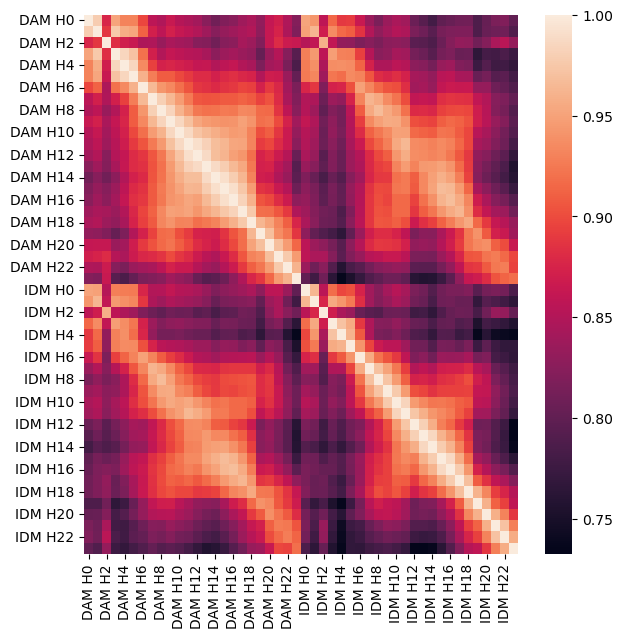

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=prices.astype(float).corr(), ax=ax)

In [70]:
parent_cell = [[] if i==0 else [i-1] for i in range(24)] # DAM  is only connected to the previous DAM
parent_cell += [[0]] # First ID3 price is only connected to the DAM
parent_cell += [[i-24, i-1] if i==25 else [i-24, i-1, i-2] for i in range(25, 48)] # The second ID3 price is connected to the DAM and precious ID3. All other ID3 prices are connected to the previous two ID3 and DAM

names = [f'DAM H{i}' for i in range(24)] + [f'ID3 H{i}' for i in range(24)]

In [72]:
R = bn_rankcorr(parent_cell=parent_cell, data=prices, var_names=names, is_data=True)

In [77]:
R = bn_rankcorr(parent_cell=parent_cell, data=prices, var_names=names, is_data=True)
condition_nodes = [c for c in range(24)]
condition_values = [v for v in prices.iloc[0, :24].values]
samples = inference(R=R, Nodes=condition_nodes, Values=condition_values, DATA=prices, SampleSize=1000)

In [85]:
samples = inference(R=R, Nodes=condition_nodes, Values=condition_values, DATA=prices, SampleSize=1000)

In [87]:
samples.shape

(1, 24, 1000)